In [1]:
from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import airfoils as afs
from shapely import LineString, Polygon, is_ccw, Point
from shapely import geometry
from shapely.plotting import plot_line, patch_from_polygon
from shapely.affinity import translate, rotate, scale, skew
from shapely import difference, unary_union
from dataclasses import dataclass, field
from pathlib import Path

In [2]:
@dataclass
class Hole:
    diameter_mm:float
    position:np.ndarray
    def __post_init__(self):
        assert self.position.shape == (2,), "position must have shape `(2)`"

@dataclass
class Airfoil:
    points:np.ndarray
    holes:list[Hole] = field(default_factory=list)

    def __post_init__(self) -> None:
        assert self.points.shape[1]==2, "points must be for shape (n, 2)" 
        assert self.points.shape[0]>4, f"need more points. only got {len(self.points)=}"
        assert (self.points[0]==self.points[-1]).all(), "first and last point must be the same"
        assert is_ccw(LineString(self.points)), "Points must be counterclockwise from trailing edge"
    
    @classmethod
    def from_naca(
            cls,
            max_camber:float,
            max_camber_position:float,
            thickness:float,
            chord_length_mm:float
        ):
        upper, lower = afs.gen_NACA4_airfoil(
            max_camber, 
            max_camber_position, 
            thickness,
            200
        )
        selig = np.vstack((upper.transpose()[::-1], lower.transpose()))
        average_terminator = (selig[0]+selig[-1])/2
        selig = np.concatenate([
            [average_terminator],
            selig,
            [average_terminator]
        ])
        return Airfoil(selig*chord_length_mm)
    
    def add_holes(self, holes:list[Hole]) -> Airfoil:
        self.holes.extend(holes)
        return self

    def show(self):
        display(LineString(self.points))
    
    def linestring(self) -> LineString:
        return LineString(self.points)
    
    def polygon(self) -> Polygon:
        return Polygon(self.points)

    def get_with_holes(self) -> Polygon:
        shapes = [Point(hole.position).buffer(hole.diameter_mm) for hole in self.holes]
        height=50
        width=1.3
        upcuts = [
            geometry.box(
                *(hole.position-np.array([width/2,-height])),
                *(hole.position+np.array([width/2,0]))
            ) for hole in self.holes
        ]
        
        return difference(self.polygon().simplify(tolerance=0.05),unary_union(shapes+upcuts))
    

    def prepare(self) -> Polygon:
        pass
        


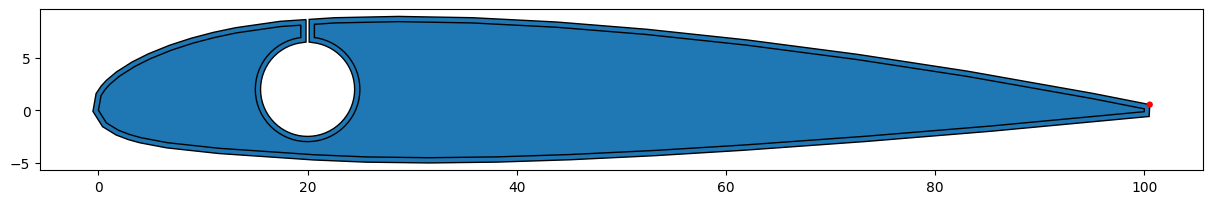

In [10]:
fix, ax = plt.subplots(figsize=(15,10))

ls = Airfoil.from_naca(
    max_camber=0.2,
    max_camber_position=0.02,
    thickness=0.13,
    chord_length_mm=100,
).add_holes(
    holes=[
        Hole(5,np.array([20,2]))
    ],
).get_with_holes()
#).polygon().simplify(tolerance=0.05)
lsb = ls.buffer(0.5, quad_segs=1, join_style="mitre")
ax.add_patch(patch_from_polygon(lsb))
ax.add_patch(patch_from_polygon(ls))
ax.autoscale_view()
ax.set_aspect('equal')

coords = np.array(lsb.boundary.coords)
pnt = coords[(coords[:,0]+coords[:,1]).argmax()]
ax.add_patch(plt.Circle(pnt,0.3, facecolor="red"))

In [ ]:
Path("out.svg").write_text(
f"""<svg version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink= "http://www.w3.org/1999/xlink">
{lsb.svg()}
</svg>
""")

4129

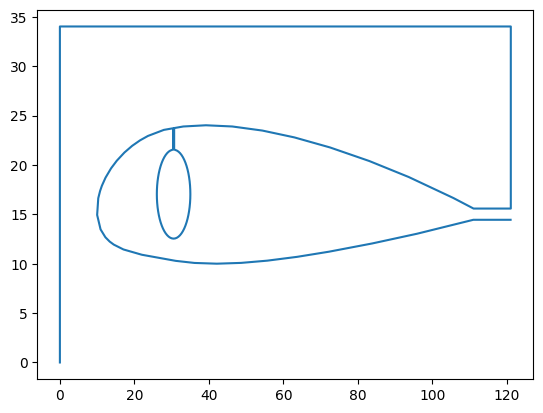

In [36]:
coords = np.array(lsb.boundary.coords)
coords = np.roll(coords,-(coords[:,0]+coords[:,1]).argmax()-1, axis=0)[::-1]
start = coords[0]
bottom_left = coords.min(axis=0)
top_right = coords.max(axis=0)
width, height = top_right-bottom_left
padding = 10
coords = np.vstack([
    [
        bottom_left - np.array([padding,padding]),
        bottom_left+np.array([-padding,height+padding]),
        top_right + np.array([padding,padding]),
        start + np.array([padding,0])
    ],
    coords,
    [
        coords[-1]+np.array([padding,0])
    ]
])
coords = coords - coords.min(axis=0)
plt.plot(*coords.transpose())

In [38]:
pd.DataFrame(coords,columns=["x","y"]).to_parquet("./data/cut_paths/01_100mm_test.parquet")

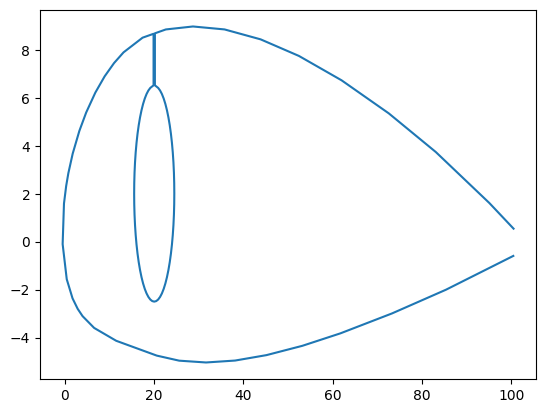

In [20]:
plt.plot(*coords.transpose())